<a href="https://colab.research.google.com/github/tcdixon4/the-riddler/blob/master/20201113_coin_flip_comebacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting improbable comebacks in coin flip competitions


---





## The problem

Two teams are facing off in a best-of-100 coin flip competition: if at least 51
of the 100 coin flips return heads, then team A wins; if at least 51 return
tails, then team B wins. Buckle up for the description of our problem, because 
there will be two layers of probabilities that might get confusing.

**What is the probability that team A will have at least a 99% chance of winning
at some point during the game, yet end up losing the competition?**


See [here](https://fivethirtyeight.com/features/can-you-snatch-defeat-from-the-jaws-of-victory/) for full setup.

## Foundational facts

A few foundational pieces of information are required to get going.



1.   **Fair coin flips follow a particularly convenient form of the binomial distribution.** If we have some random process (like the coin flip) that has a distinct probability of returning a binary outcome (like heads or tails), and we independently repeat the process multiple times, then the probability that the number of positive outcomes equals a certain value, `k`, is described by the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). The only parameters needed are the number of repetitions, `n`, and the probability of a single repetition returning a positive outcome, `p`. When `p`=0.5, the probability density function simplifies in a way that we will discuss later.
2.   **The binomial distribution can be approximated by the normal distribution in certain situations.** At large values of `n` and values of `p` near 0.5, the binomial distribution can be approximated by the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), with $\mu$ =`np` and $\sigma$=`np(1-p)`. This will come in handy for the extra credit question. 



## Formalizing the problem
We want to know the probability that two conditions are met.
1. The probability that team A will win given the previous coin flips is at least 99% at some point in the game.
2. Team A ends up losing.

Let's think about this intuitively for a moment. The probability that team A will win should be high when there have been many heads already flipped and plenty of flips left to complete the number of heads neededto eclipse 51.  

We mentioned that this coin flipping process follows the binomial distribution:

> $ X ~ Bin(n,p) $
>
> $ P(X=k) = {n \choose k} p^k(1-p)^{n-k}$
>
> $ \hspace{20pt} p=0.5$
> 
> $ P(X=k) = {n \choose k} 0.5^n$
> 

Therefore, at any point in the game (i.e. any number of the 100 flips that have already been completed) we can calculate the probability of obtaining the remaining number of heads necessary to win given the number that have already appeared. This is formalized in the equation and figure below, showing the conditional probability of losing given a certain number of heads and total flips at an intermediate stage of the competition:

> $ P(loss | x_0,n_0) = P(x_0 + X_1 \leq 50|x_0,n_0) = P(X_1 \leq 50-x_0|x_0,n_0) $
>
> $ \hspace{20pt} $ where $ x_0 $ is the number of heads already in the bank
>
> $ \hspace{44pt} $  $ n_0 $ is the number of completed flips
>
> $ \hspace{44pt} $ $ X_1 $ is the number of heads yet to be realized in the remaining $ n_1 $ flips
> 
> $ P(loss | x_0,n_0) =  \sum\limits_{x_1=0}^{50-x_0} {100-n_0 \choose x_1} 0.5^{100-n_0}$
>

In words, this is the sum of all probabilities for events where we start with some number of heads in some number of completed coin flips and do not end up with over 50 heads. This conditional loss probability is shown in the heatmap below, where the color of each cell shows the probability of loss given some number of completed coin flips (X-axis) and some number of already-seen heads (Y-axis).



In [1]:
#@title
# Import dependencies
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

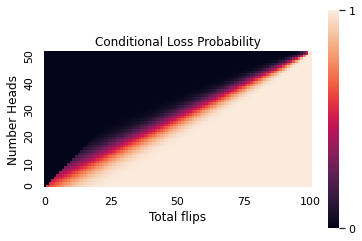

In [23]:
#@title
p_cond = np.zeros([101,101])
for n0 in range(101):
  for k0 in range(n0):
    p_cond[k0,n0] = binom.cdf(50-k0,100-n0,0.5)
    
ax = sns.heatmap(p_cond[:51,:], square=True, xticklabels=25, yticklabels=10)
ax.invert_yaxis()
ax.set_title('Conditional Loss Probability', color='black')
ax.set_xlabel('Total flips', color='black')
ax.set_ylabel('Number Heads', color='black')
ax.tick_params(labelcolor='black')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1])
cbar.ax.tick_params(labelcolor='black')


We can sanity check this by seeing what the probability of loss is if you flipped all 100 coins and got 0 heads. This should be 1, and it is.



## Solving the problem
Now, specifically what we are interested in is all games where the win probability was over 0.99 at **some point** in the game. We can certainly calculate the probability of entering any state where the remaining win probability is above 0.99, but we will hit a tricky situation where we want to avoid counting a game twice if the win probability was above 0.99 at more than one point in the game. You could make clever use of the [inclusion-exclusion principle](https://en.wikipedia.org/wiki/Inclusion%E2%80%93exclusion_principle), but instead we are going to solve this problem by simulation.

Essentially, we will simulate many games and flag all games where **at some point** there was a conditional loss probability below 1%. At each flip in each simulation, we will simply check this using the formula above (that was used to make the heatmap). We will also flag games where team A ended up losing. The final probability that we seek, representing the joint of these two event probabilities, will be the proportion of simulations that receive both flags.

In [54]:
#@title
def sim_coin_game():
  n1_vec = np.arange(99,-1,-1) # helper variable: remaining coin flips
  cur_sim = np.random.randint(2, size=100) # randomize all 100 flips
  h_need = 50-np.cumsum(cur_sim) # number of remaining heads needed to break 50
  win_prob = 1 - binom.cdf(h_need,n1_vec,0.5) # calculate win prob at each point
  flag_1 = any(win_prob>0.99) # flag if win_prob was ever above 0.99
  flag_2 = h_need[-1] > 0 # flag if there were more than 50 heads at the end

  return flag_1 and flag_2

In [55]:
sims = np.zeros([100000,1])
for sim in range(100000):
  sims[sim] = sim_coin_game()
  
np.mean(sims)

0.00053

Our finaly probability is approximately 0.0005, or 0.05%. That is very unlikely!

## Extra credit

If we consider the limit as $ n \to \infty $, then the proportion of heads out of the total converges on the normal distribution, as stated above. 

If we express the random variable as the proportion of heads, then: 
> $ \lim\limits_{n \to \infty} \mu = \frac{np}{n} = p = 0.5 $
>
> $ \lim\limits_{n \to \infty} \sigma = \frac{np(1-p)}{n} = p(1-p) = 0.25 $